## Imports & Setup

In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Compose, Resize, RandomHorizontalFlip, Grayscale, Normalize
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score
from helpers import *
from architecture.CNN import *
from architecture.AutoEncoder import *

In [2]:
# pip install torchsampler
from torchsampler import ImbalancedDatasetSampler

In [3]:
torch.manual_seed(168)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Prepare Dataset

In [5]:
size = 32
batch_size = 128
transformation = Compose([RandomHorizontalFlip(), Grayscale(1), 
                          Resize((size, size)), ToTensor(), Normalize(mean=[0.4815], std=[0.2135])])

In [6]:
root = 'chest_xray/train'
train_data = create_dataset(root, transformation)
sampler_train = ImbalancedDatasetSampler(train_data)
train_loader = produce_loader(train_data, batch_size, sampler_train)

In [7]:
root = 'chest_xray/test'
test_data = create_dataset(root, transformation)
test_loader = produce_loader(test_data, batch_size)

In [8]:
root = 'chest_xray/val'
val_data = create_dataset(root, transformation)
val_loader = produce_loader(val_data, batch_size)

[1097, 663, 1213, 1321, 613, 2902, 200, 2016, 489]


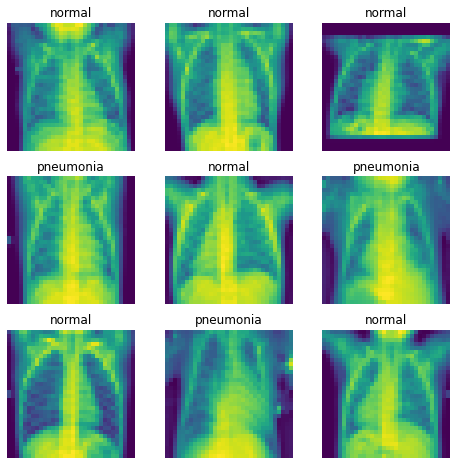

In [9]:
visualize_data(train_data)

[584, 69, 24, 484, 372, 136, 134, 28, 469]


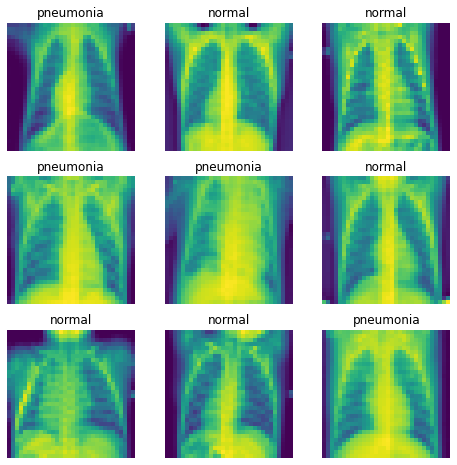

In [10]:
visualize_data(test_data)

## Load AutoEncoder

In [11]:
# number of hidden layers and their sizes
hidden_a = [1, 32, 64, 128, 256]

# kernel size of convolution layers
kernel_size_a = 3

In [12]:
autoencmodel = AutoEncoder(hidden_a, kernel_size_a).to(device)
autoencmodel.load_state_dict(torch.load("./autoencoder256")["model_state_dict"])

<All keys matched successfully>

In [13]:
# freeze autoencoder parameters
for param in autoencmodel.parameters():
    param.requiresGrad = False
print(autoencmodel)

AutoEncoder(
  (enc_combined): Sequential(
    (0): Encoder(
      (conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
      (batchnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.01)
    )
    (1): Encoder(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.01)
    )
    (2): Encoder(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.01)
    )
    (3): Encoder(
      (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
      (batchnorm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.01)
    )
  )
  (dec_combined): Seq

## Initialise Model

In [14]:
def create_adam_optimizer(model, lr = 0.1, betas=(0.9, 0.999), amsgrad=False, weight_decay=1e-5):
    return optim.Adam(model.parameters(), lr = lr, amsgrad=amsgrad, betas=betas, weight_decay=weight_decay)

In [15]:
from math import floor
#sharp sobel kernels
kernels = [torch.tensor([[0., -1., 0.],
                        [-1., 5., -1.],
                        [0., -1., 0.]]),
           torch.tensor([[1., 2., 1.],
                        [0., 0., 0.],
                        [-1., -2., -1.]]),
           torch.tensor([[1., 0., -1.],
                        [2., 0., -2.],
                        [1., 0., -1.]])]

kernels5=[torch.tensor([[2.,2.,4.,2.,2.],
                      [1.,1.,2.,1.,1.],
                      [0.,0.,0.,0.,0.],
                      [-1.,-1.,-2.,-1.,-1.],
                      [-2.,-2.,-4.,-2.,-2.]]),
         torch.tensor([[2., 1., 0., -1., -2.],
                      [2., 1., 0., -1., -2.],
                      [4., 2., 0., -2., -4.],
                      [2., 1., 0., -1., -2.],
                      [2., 1., 0., -1., -2.]]),
         torch.tensor([[-1/256,-4/256,-6/256,-4/256,-1/256],
                      [-4/256,-16/256,-24/256,-16/256, -4/256],
                      [-6/256, -24/256, 476/256, -24/256, -6/256],
                      [-4/256,-16/256,-24/256,-16/256, -4/256],
                      [-1/256,-4/256,-6/256,-4/256,-1/256]])] #unsharp masking

# number of hidden layers and their sizes
hidden = [256,512,128]
hidden_list=[[256, 256, 128, 64], [1, 256, 128, 64]]

# kernel size of convolution layers
kernel_size = 3

# window size of maxpooling layer
window = 2

# calculate final size of image
new_size = size-(kernel_size_a-1)*(len(hidden_a)-1)
channels = hidden[-1]
changed_img = floor( (new_size-(kernel_size-1)*(len(hidden)-1)) / window )

# calculate dimension of flattened image
flattened = channels*changed_img*changed_img

# final linear layers and their sizes
hidden_linear = [flattened, 512, 64]
dropout=0.5

In [16]:
model = DeepLearn(kernels=kernels, hidden=hidden, kernel_size=kernel_size,
                  window=window, hidden_linear=hidden_linear, dropout=dropout).to(device)
print(model)

DeepLearn(
  (conv_combined): Sequential(
    (0): DeepLearnConv(
      (conv): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
      (batch_norm): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout2d(p=0.5, inplace=False)
    )
    (1): DeepLearnConv(
      (conv): Conv2d(512, 128, kernel_size=(3, 3), stride=(1, 1))
      (batch_norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout2d(p=0.5, inplace=False)
    )
  )
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear_combined): Sequential(
    (0): DeepLearnLinear(
      (linear): Linear(in_features=12800, out_features=512, bias=True)
      (batch_norm): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (1): DeepLearnLinear(
      (linear): Linear(in_features=512, out_features=64, bias=Tr

## Training Model

In [17]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
epochs=10

In [18]:
optimizer = create_adam_optimizer(model, lr=0.01)

In [19]:
# repeat this cell with epochs = 1 for safety, but usually epochs = 3 is a good start

"""
train function params:
device
model - model to train
train_loader - training data loader
val_loader - validation data loader
optimizer - optimizer to use (allows for saving and reloading optimizer state to stop and resume training)
epochs
criterion - loss function to use (default is cross entropy)
autoencoder - autoencoder to use, if any (default is None)

returns lists of the training loss, training accuracy, validation loss and validation accuracy for plotting curves

"""
tl, ta, vl, va = train(device, model,
                       train_loader, val_loader, 
                       optimizer, epochs = 9, autoencoder=autoencmodel)
train_losses+=tl
train_accuracies+=ta
val_losses+=vl
val_accuracies+=va

Epoch 1/9, Batch number: 0, Cumulated accuracy: 0.3984375


KeyboardInterrupt: 

## Hyperparam Tuning

In [18]:
#Hyperparameters
from math import floor

#sharp sobel kernels
kernels3 = [torch.tensor([[0., -1., 0.],
                        [-1., 5., -1.],
                        [0., -1., 0.]]),
           torch.tensor([[1., 2., 1.],
                        [0., 0., 0.],
                        [-1., -2., -1.]]),
           torch.tensor([[1., 0., -1.],
                        [2., 0., -2.],
                        [1., 0., -1.]])]

kernels5=[torch.tensor([[2.,2.,4.,2.,2.],
                      [1.,1.,2.,1.,1.],
                      [0.,0.,0.,0.,0.],
                      [-1.,-1.,-2.,-1.,-1.],
                      [-2.,-2.,-4.,-2.,-2.]]),
         torch.tensor([[2., 1., 0., -1., -2.],
                      [2., 1., 0., -1., -2.],
                      [4., 2., 0., -2., -4.],
                      [2., 1., 0., -1., -2.],
                      [2., 1., 0., -1., -2.]]),
         torch.tensor([[-1/256,-4/256,-6/256,-4/256,-1/256],
                      [-4/256,-16/256,-24/256,-16/256, -4/256],
                      [-6/256, -24/256, 476/256, -24/256, -6/256],
                      [-4/256,-16/256,-24/256,-16/256, -4/256],
                      [-1/256,-4/256,-6/256,-4/256,-1/256]])] #unsharp masking

# number of hidden neurons in Conv layers and their sizes
hidden = [256, 256, 128, 64]
hidden_list=[[256, 256, 128, 64], [256, 512,128,64], [256,512,128]]

# kernel size of convolution layers
kernel_size = 3


# window size of maxpooling layer
window = 2


# calculate final size of image
new_size = size-(kernel_size_a-1)*(len(hidden_a)-1)
channels = hidden[-1]
changed_img = floor( (new_size-(kernel_size-1)*(len(hidden)-1)) / window )

# calculate dimension of flattened image
flattened = channels*changed_img*changed_img

# final linear layers and their sizes
hidden_linear = [flattened, 512, 64]


#learning rate of optimiser
lr=0.01



#hyperparams

weight_decay=1e-5

hidden_list=[[256, 256, 128, 64], [256, 512,128,64], [256,512,128]]

kernel_list=[3,5]

window_list=[2,3,5]

hidden_linear_list=[[flattened, 512, 64],  [flattened,1024, 512], [flattened,1024,512,256]]

lr_list=[0.01,0.005,0.001]

dropout_list=[0.3,0.5,0.7]

In [19]:
test_param="dropout" #edit param name
test_losses = []
test_accuracies = []
precision_list=[]
recall_list=[]
f1_list=[]
epochs=10
 
for dropout in dropout_list: #edit param list and name
    print(test_param+'='+str(dropout)) #edit param name in str
    new_size = size-(kernel_size_a-1)*(len(hidden_a)-1)
    channels = hidden[-1]
    changed_img = floor( (new_size-(kernel_size-1)*(len(hidden)-1)) / window )
    flattened = channels*changed_img*changed_img
    hidden_linear[0]=flattened
    if(kernel_size==3):
        kernels=kernels3
    elif(kernel_size==5):
        kernels=kernels5
    
    model = DeepLearn(kernels=kernels, hidden=hidden, kernel_size=kernel_size,
                  window=window, hidden_linear=hidden_linear, dropout=dropout).to(device)
    
    
   
    optimizer = create_adam_optimizer(model, lr=lr, weight_decay=weight_decay)
    
    tl, ta, vl, va = train(device, model,
                       train_loader, val_loader, 
                       optimizer, epochs = epochs, autoencoder=autoencmodel)
    true_labels, model_preds, test_loss, test_accuracy = test(device, model, test_loader, autoencoder=autoencmodel, get_predictions=True)
    p,r,f= return_metrics(true_labels, model_preds)
                           
    test_losses+=[test_loss]
    test_accuracies+=[test_accuracy]
    precision_list+=[p]
    recall_list+=[r]
    f1_list+=[f]


dropout=0.3
Epoch 1/10, Batch number: 0, Cumulated accuracy: 0.5390625
Epoch 1/10, Batch number: 5, Cumulated accuracy: 0.7174479166666666
Epoch 1/10, Batch number: 10, Cumulated accuracy: 0.7535511363636364
Epoch 1/10, Batch number: 15, Cumulated accuracy: 0.7734375
Epoch 1/10, Batch number: 20, Cumulated accuracy: 0.7853422619047619
Epoch 1/10, Batch number: 25, Cumulated accuracy: 0.7905649038461539
Epoch 1/10, Batch number: 30, Cumulated accuracy: 0.7986391129032258
Epoch 1/10, Batch number: 35, Cumulated accuracy: 0.8044704861111112
--- Epoch 1/10: Train loss: 0.4241, Train accuracy: 0.8047
--- Epoch 1/10: Val loss: 0.4056, Val accuracy: 0.8137
Epoch 2/10, Batch number: 0, Cumulated accuracy: 0.875
Epoch 2/10, Batch number: 5, Cumulated accuracy: 0.8684895833333334
Epoch 2/10, Batch number: 10, Cumulated accuracy: 0.8735795454545454
Epoch 2/10, Batch number: 15, Cumulated accuracy: 0.86962890625
Epoch 2/10, Batch number: 20, Cumulated accuracy: 0.8634672619047619
Epoch 2/10, Batch

Epoch 3/10, Batch number: 35, Cumulated accuracy: 0.8637152777777778
--- Epoch 3/10: Train loss: 0.3319, Train accuracy: 0.8634
--- Epoch 3/10: Val loss: 0.3813, Val accuracy: 0.8205
Epoch 4/10, Batch number: 0, Cumulated accuracy: 0.8359375
Epoch 4/10, Batch number: 5, Cumulated accuracy: 0.8645833333333334
Epoch 4/10, Batch number: 10, Cumulated accuracy: 0.8693181818181818
Epoch 4/10, Batch number: 15, Cumulated accuracy: 0.87060546875
Epoch 4/10, Batch number: 20, Cumulated accuracy: 0.8727678571428571
Epoch 4/10, Batch number: 25, Cumulated accuracy: 0.8734975961538461
Epoch 4/10, Batch number: 30, Cumulated accuracy: 0.8732358870967742
Epoch 4/10, Batch number: 35, Cumulated accuracy: 0.8747829861111112
--- Epoch 4/10: Train loss: 0.2953, Train accuracy: 0.8747
--- Epoch 4/10: Val loss: 0.2921, Val accuracy: 0.8684
Epoch 5/10, Batch number: 0, Cumulated accuracy: 0.90625
Epoch 5/10, Batch number: 5, Cumulated accuracy: 0.8802083333333334
Epoch 5/10, Batch number: 10, Cumulated ac

Epoch 6/10, Batch number: 20, Cumulated accuracy: 0.8608630952380952
Epoch 6/10, Batch number: 25, Cumulated accuracy: 0.8611778846153846
Epoch 6/10, Batch number: 30, Cumulated accuracy: 0.8578629032258065
Epoch 6/10, Batch number: 35, Cumulated accuracy: 0.8582899305555556
--- Epoch 6/10: Train loss: 0.3462, Train accuracy: 0.8587
--- Epoch 6/10: Val loss: 0.3226, Val accuracy: 0.8667
Epoch 7/10, Batch number: 0, Cumulated accuracy: 0.8671875
Epoch 7/10, Batch number: 5, Cumulated accuracy: 0.8619791666666666
Epoch 7/10, Batch number: 10, Cumulated accuracy: 0.8622159090909091
Epoch 7/10, Batch number: 15, Cumulated accuracy: 0.8642578125
Epoch 7/10, Batch number: 20, Cumulated accuracy: 0.8642113095238095
Epoch 7/10, Batch number: 25, Cumulated accuracy: 0.8662860576923077
Epoch 7/10, Batch number: 30, Cumulated accuracy: 0.8671875
Epoch 7/10, Batch number: 35, Cumulated accuracy: 0.8682725694444444
--- Epoch 7/10: Train loss: 0.3214, Train accuracy: 0.8683
--- Epoch 7/10: Val loss:

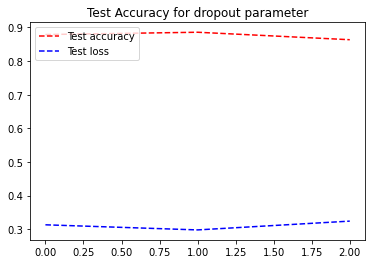

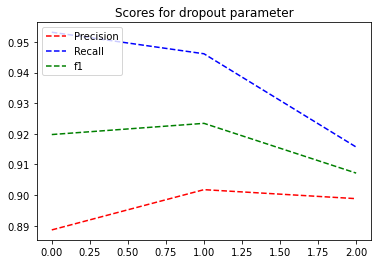

In [20]:
plt.plot(test_accuracies, "r--", label='Test accuracy')
plt.plot(test_losses, "b--", label='Test loss')
plt.title(f'Test Accuracy for {test_param} parameter')
plt.legend(loc='upper left')
plt.show()

plt.plot(precision_list, "r--", label='Precision')
plt.plot(recall_list, "b--", label='Recall')
plt.plot(f1_list, "g--", label='f1')
plt.title(f'Scores for {test_param} parameter')
plt.legend(loc='upper left')
plt.show()

In [21]:
print(f'test accuracy: {test_accuracies}')
print(f'test loss: {test_losses}')
print(f'precision: {precision_list}')
print(f'recall: {recall_list}')
print(f'f1 score: {f1_list}')

test accuracy: [0.8786324786324786, 0.8854700854700854, 0.8632478632478633]
test loss: [0.3133301019668579, 0.29813455045223236, 0.32427139282226564]
precision: [0.888646288209607, 0.9017857142857143, 0.8988505747126436]
recall: [0.9531615925058547, 0.9461358313817331, 0.9156908665105387]
f1 score: [0.919774011299435, 0.9234285714285715, 0.9071925754060326]


## Testing Model & Performance Curves

In [21]:
"""
test function params:
device
model - model to train
data_loader - chosen (testing) data loader
criterion - loss function to use (default is cross entropy)
autoencoder - autoencoder to use, if any (default is None)
get_predictions - if True, returns the list of true labels, the list of predictions made by the model, 
                  and values of the test loss and test accuracy (default is False)

by default, returns values of the test loss and test accuracy

"""
true_labels, model_preds, test_loss, test_accuracy = test(device, model, test_loader, autoencoder=autoencmodel, get_predictions=True)

Test loss: 0.2951, Test accuracy: 0.8752


Precision: 0.875
Recall: 0.9672131147540983
F1 score: 0.9187986651835371


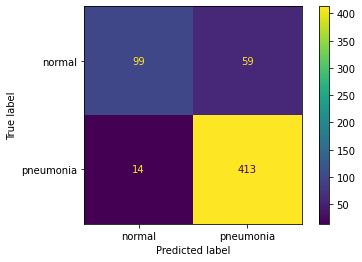

In [22]:
show_metrics(true_labels, model_preds)

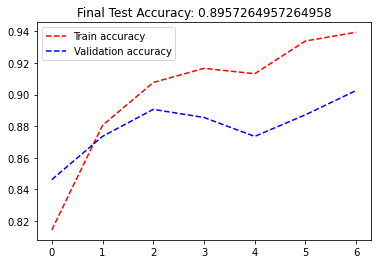

In [42]:
plt.plot(train_accuracies, "r--", label='Train accuracy')
plt.plot(val_accuracies, "b--", label='Validation accuracy')
plt.title("Final Test Accuracy: {}".format(test_accuracy))
plt.legend(loc='upper left')
plt.show()

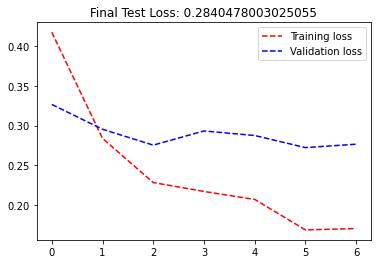

In [43]:
plt.plot(train_losses, "r--", label='Training loss')
plt.plot(val_losses, "b--", label='Validation loss')
plt.title("Final Test Loss: {}".format(test_loss))
plt.legend(loc='upper right')
plt.show()

## Viewing Model Predictions

In [44]:
test_loader2 = produce_loader(test_data, 1)

In [53]:
correct_list, wrong_list, true_labels2, model_preds2 = get_pictures_test(device, model, test_loader2, autoencoder=autoencmodel)

Precision: 0.9384236453201971
Recall: 0.892271662763466
F1 score: 0.9147659063625452


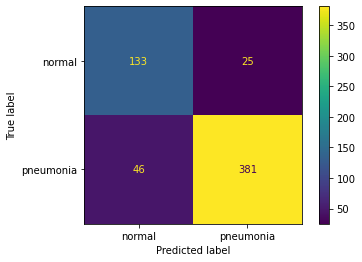

In [54]:
show_metrics(true_labels2, model_preds2)

[396, 374, 484, 362, 207, 513, 281, 502, 72, 249, 153, 196, 331, 71, 1, 473, 59, 0, 110, 38, 123, 135, 83, 211, 347]


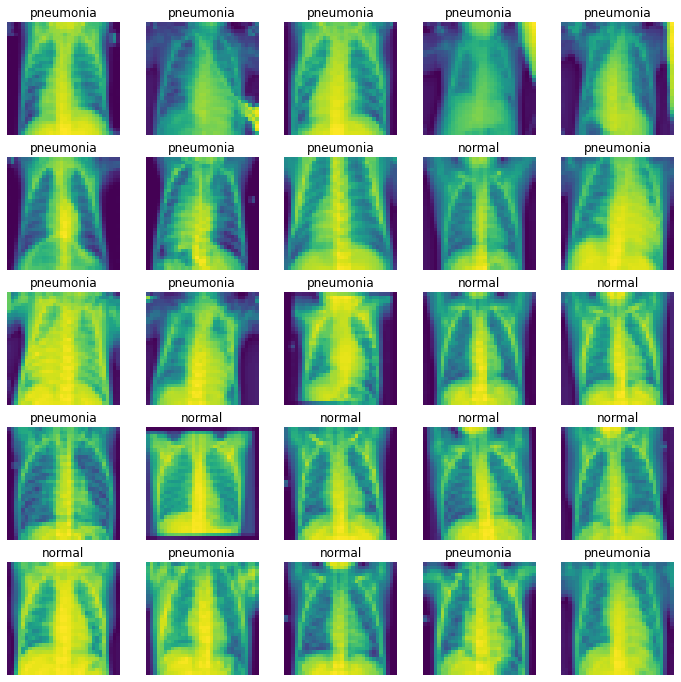

In [55]:
visualize_data(correct_list, (12,12), 5)

[60, 37, 59, 23, 40, 64, 7, 2, 6, 32, 70, 70, 47, 30, 60, 20, 69, 8, 46, 68, 8, 35, 2, 34, 29]


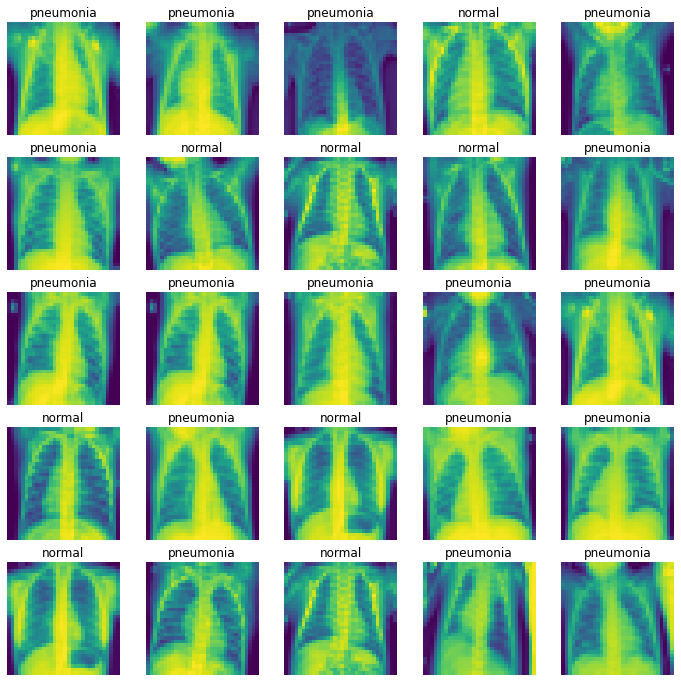

In [56]:
visualize_data(wrong_list, (12,12), 5)

## Saving Model

In [ ]:
torch.save({'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()}, 
            './CNNwAE')

model_test = DeepLearn(kernels=kernels, hidden=hidden, kernel_size=kernel_size, window=window,
                   hidden_linear=hidden_linear, labels=labels).to(device)
model_test.load_state_dict(torch.load("./latest_16epochs")["model_state_dict"])